In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import time

np.random.seed(42)

X, y = make_classification(
    n_samples=3000,
    n_features=25,
    n_informative=20,
    n_redundant=5,
    n_clusters_per_class=3,
    flip_y=0.15,
    class_sep=0.6,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")

Dataset: 3000 samples, 25 features


## __Random Search__

In [2]:
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),  # 0.6 to 1.0
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 0.5),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(1, 2)
}

random_search = RandomizedSearchCV(
    XGBClassifier(random_state=42,eval_metric="logloss"),
    param_dist,
    n_iter=30,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
random_search.fit(X_train, y_train)
search_time = time.time() - start_time

print(f"Total search time: {search_time:.2f}s")
print(f"Best hyperparameter combination: {random_search.best_params_}")
print(f"Best performance: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Total search time: 22.42s
Best hyperparameter combination: {'colsample_bytree': np.float64(0.9395655297064336), 'gamma': np.float64(0.3608647605824366), 'learning_rate': np.float64(0.08079547592468672), 'max_depth': 8, 'n_estimators': 152, 'reg_alpha': np.float64(0.04043358953843135), 'reg_lambda': np.float64(2.421325779371575), 'subsample': np.float64(0.6443563283247326)}
Best performance: 0.7576


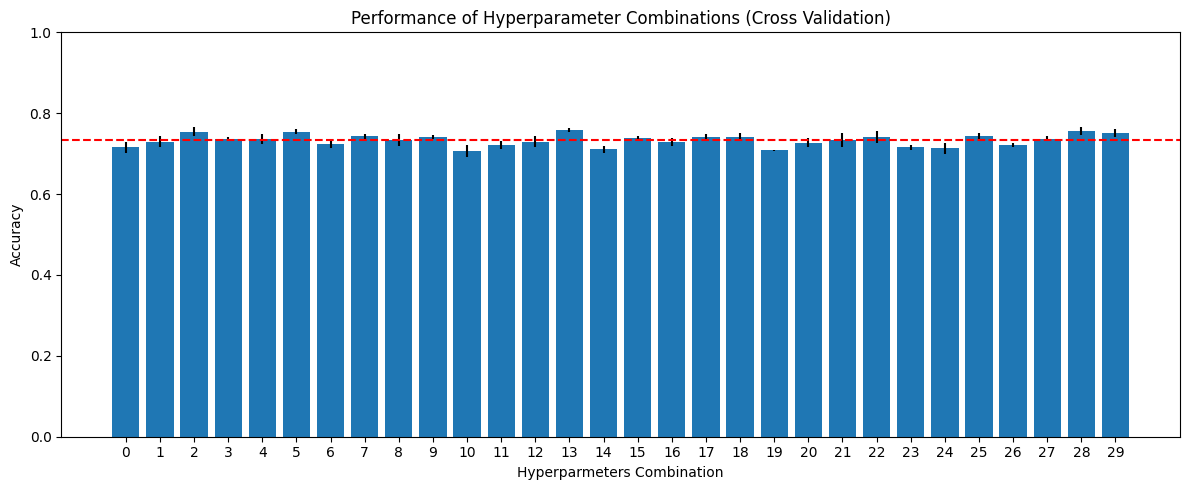

In [3]:
mean_scores = random_search.cv_results_["mean_test_score"]
std_scores = random_search.cv_results_["std_test_score"]
labels = [str(i) for i in range(len(mean_scores))]

fig, axes = plt.subplots(figsize=(12, 5))

plt.bar(labels, mean_scores, yerr = std_scores)
plt.axhline(np.mean(mean_scores), color = "red", linestyle = "--")
plt.title("Performance of Hyperparameter Combinations (Cross Validation)")
plt.xlabel("Hyperparmeters Combination")
plt.ylabel("Accuracy")
plt.ylim([0, 1])

plt.tight_layout()
plt.savefig("./figures/opt_cross_validation.png")
plt.show()

## __Best Model__

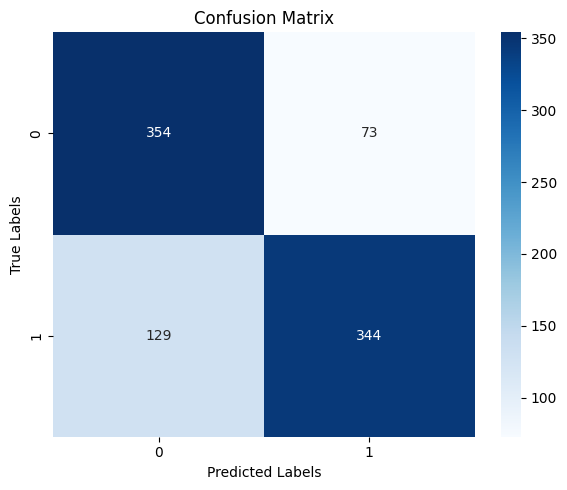

In [4]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.savefig("./figures/confusion_matrix_xgb.png")
plt.show()